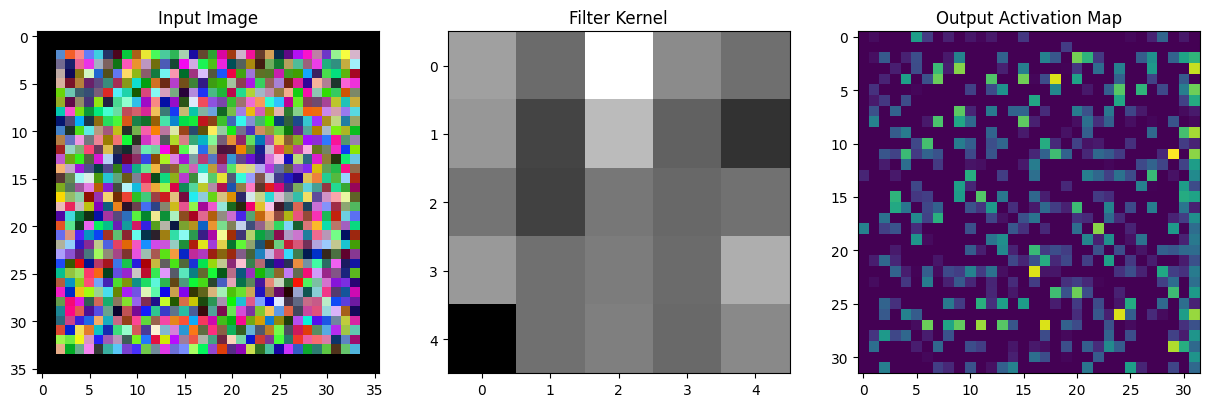

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def apply_padding(image, padding):
    if padding > 0:
        return np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant')
    return image

def convolution(image, kernel, stride=1, padding=0, activation=None, plot = True):

    image = apply_padding(image, padding)
    h, w, c = image.shape
    kh, kw, kc = kernel.shape
    
    assert kc == c, "Kernel depth must match image depth"

    out_height = (h - kh) // stride + 1
    out_width = (w - kw) // stride + 1
    output = np.zeros((out_height, out_width))

    for i in range(0, out_height):
        for j in range(0, out_width):
            region = image[i*stride:i*stride+kh, j*stride:j*stride+kw, :]
            output[i, j] = np.sum(region * kernel)
    
    if activation:
        if activation == 'sigmoid':
            output = 1 / (1 + np.exp(-output))
        elif activation == 'tanh':
            output = np.tanh(output)
        elif activation == 'relu':
            output = np.maximum(0, output)
        elif activation == 'prelu':
            output = np.where(output > 0, output, 0.01 * output)
            
    
    if plot:  
    
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(image.astype(np.uint8))

        plt.subplot(1, 3, 2)
        plt.title("Filter Kernel")
        plt.imshow(kernel[:, :, 0], cmap='gray')  
        plt.subplot(1, 3, 3)
        plt.title("Output Activation Map")
        plt.imshow(output, cmap='viridis')
        
        plt.show()
    
    # else:
    #     print("No plotting")
    
    return output


image = np.random.rand(32, 32, 3) * 255  
kernel = np.random.randn(5, 5, 3)  

output = convolution(image, kernel, stride=1, padding=2, activation='relu')


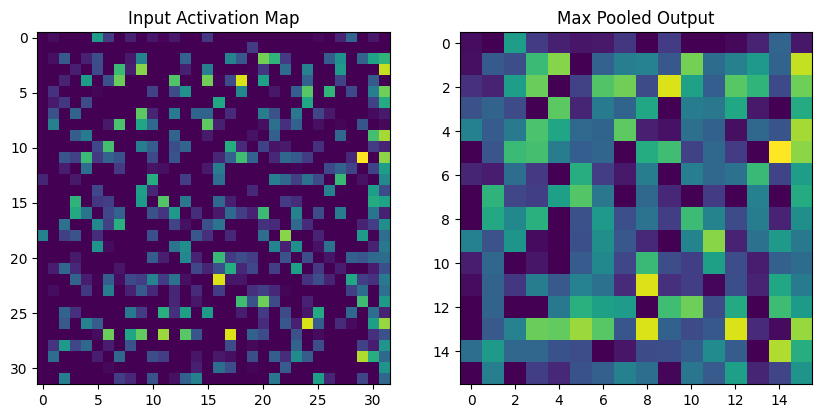

In [56]:
def pooling(input_map, pool_size=2, stride=2, pool_type='max', plot = True):
    h, w = input_map.shape
    out_height = (h - pool_size) // stride + 1
    out_width = (w - pool_size) // stride + 1
    pooled_output = np.zeros((out_height, out_width))

    for i in range(0, out_height):
        for j in range(0, out_width):
            region = input_map[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size]
            
            if pool_type == 'max':
                pooled_output[i, j] = np.max(region)
            elif pool_type == 'avg':
                pooled_output[i, j] = np.mean(region)
                
    if plot:

        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.title("Input Activation Map")
        plt.imshow(input_map, cmap='viridis')
        
        plt.subplot(1, 2, 2)
        plt.title(f"{pool_type.capitalize()} Pooled Output")
        plt.imshow(pooled_output, cmap='viridis')
        
        plt.show()
    
    # else:
    #     print("No plotting")

    return pooled_output


pooled_output = pooling(output, pool_size=2, stride=2, pool_type='max')


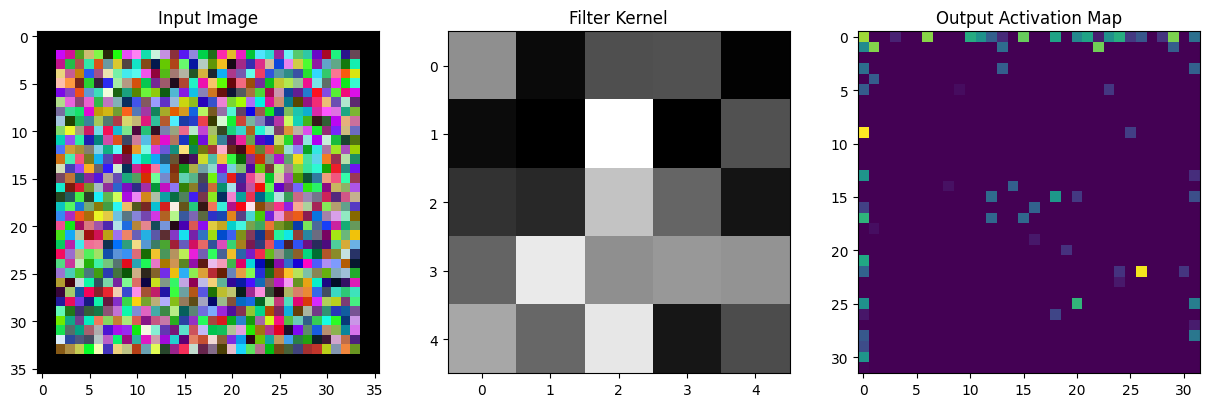

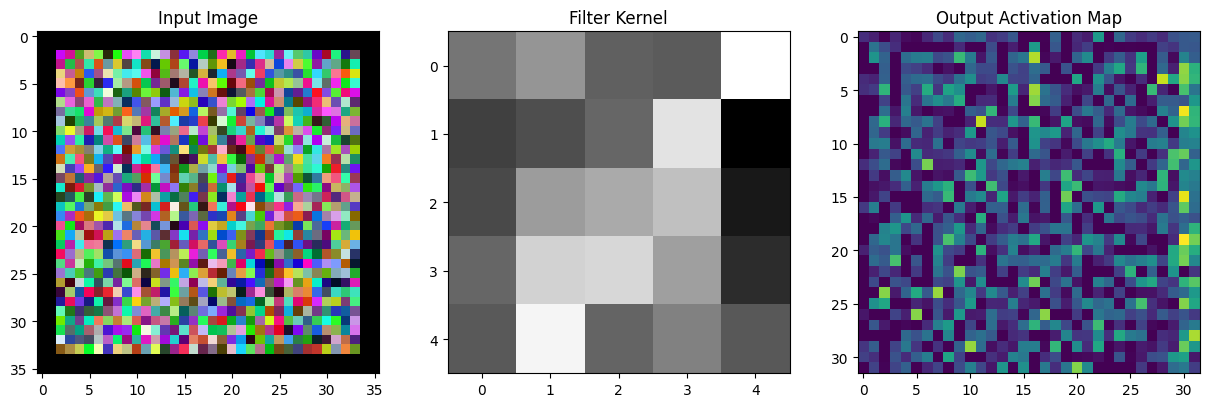

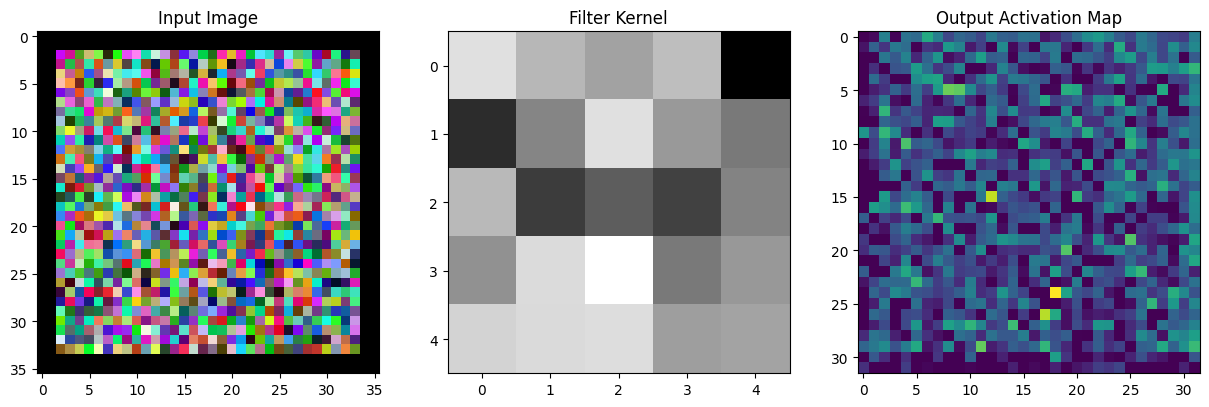

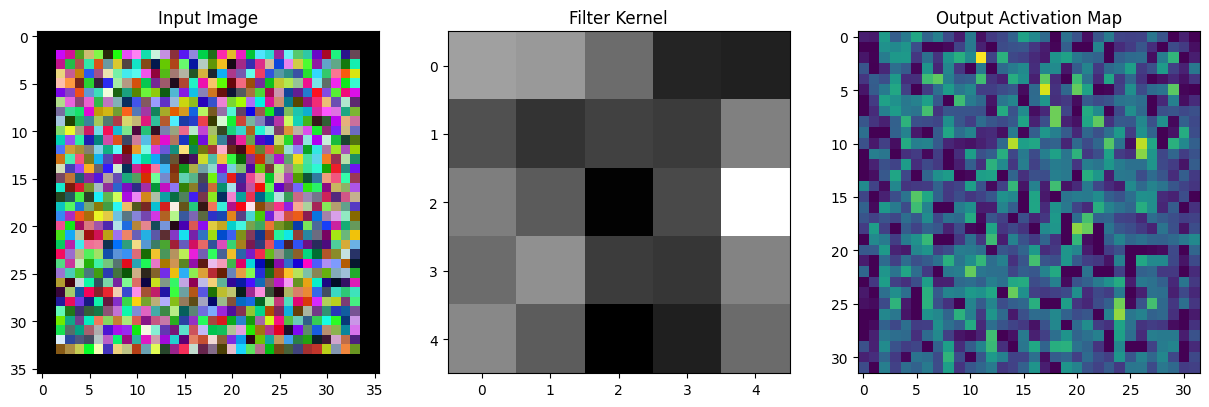

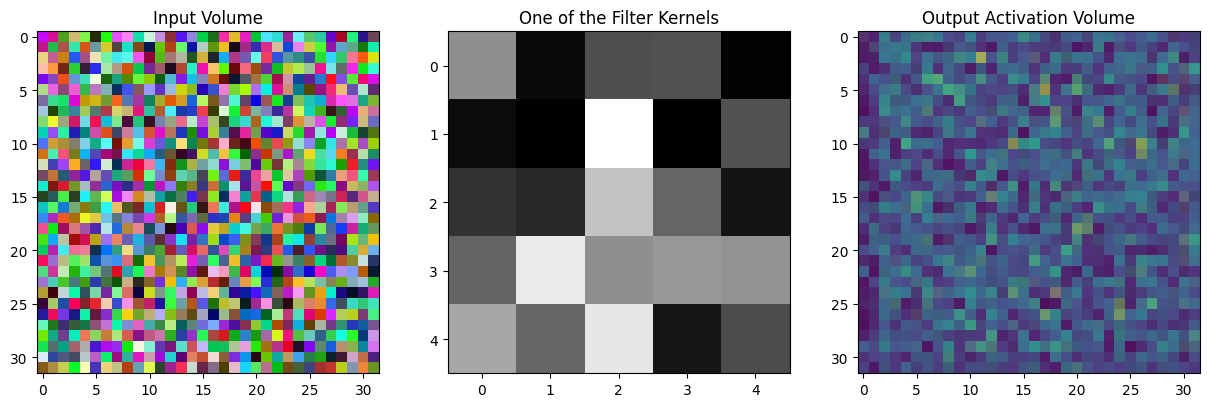

In [57]:
def convolution_layer(volume, kernels, stride=1, padding=0, activation=None, plot = True):
    h, w, c = volume.shape
    num_kernels, kh, kw, kc = kernels.shape

    assert kc == c, "Kernel depth must match input volume depth"

    out_height = (h - kh + 2 * padding) // stride + 1
    out_width = (w - kw + 2 * padding) // stride + 1
    output_volume = np.zeros((out_height, out_width, num_kernels))

    for k in range(num_kernels):
        output_volume[:, :, k] = convolution(volume, kernels[k], stride, padding, activation, plot)
    
    if plot:

        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.title("Input Volume")
        plt.imshow(volume.astype(np.uint8))

        plt.subplot(1, 3, 2)
        plt.title("One of the Filter Kernels")
        plt.imshow(kernels[0, :, :, 0], cmap='gray') 

        plt.subplot(1, 3, 3)
        plt.title("Output Activation Volume")
        for k in range(num_kernels):
            plt.imshow(output_volume[:, :, k], cmap='viridis', alpha=0.5)
        
        plt.show()

    
    return output_volume


input_volume = np.random.rand(32, 32, 3) * 255  
kernels = np.random.randn(4, 5, 5, 3)  

output_volume = convolution_layer(input_volume, kernels, stride=1, padding=2, activation='relu')


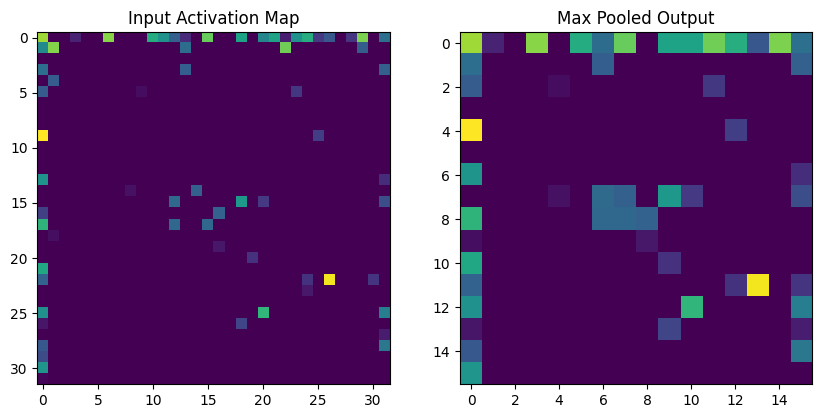

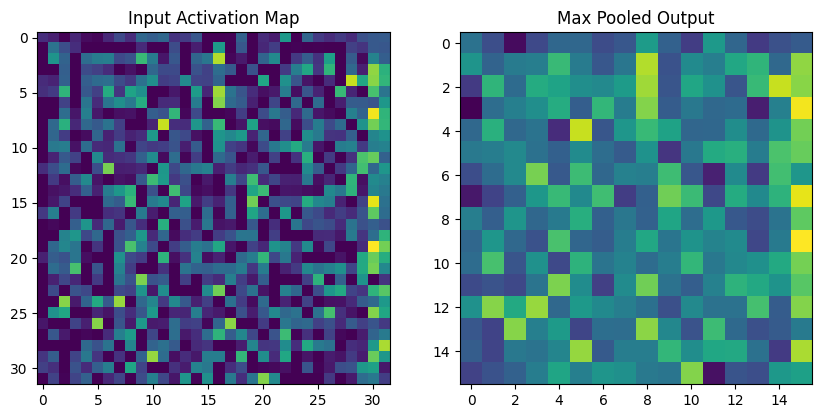

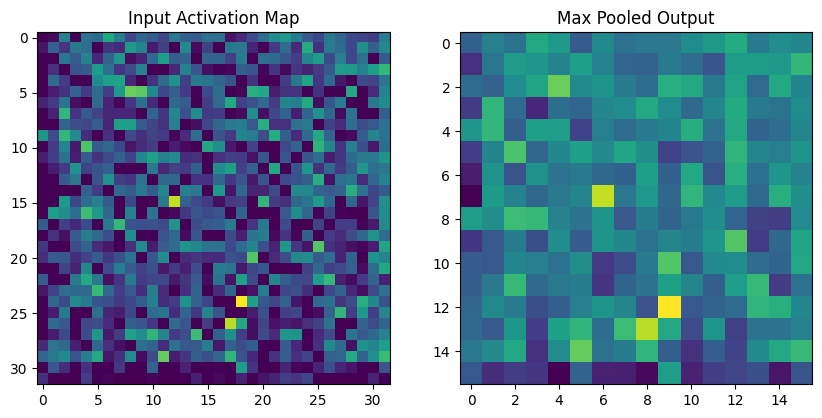

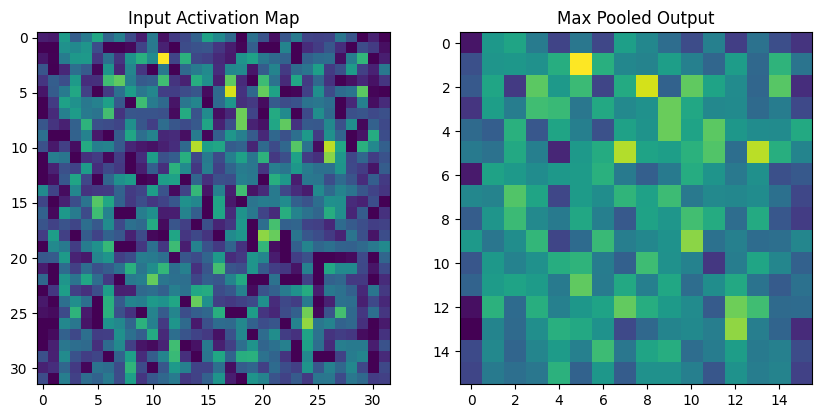

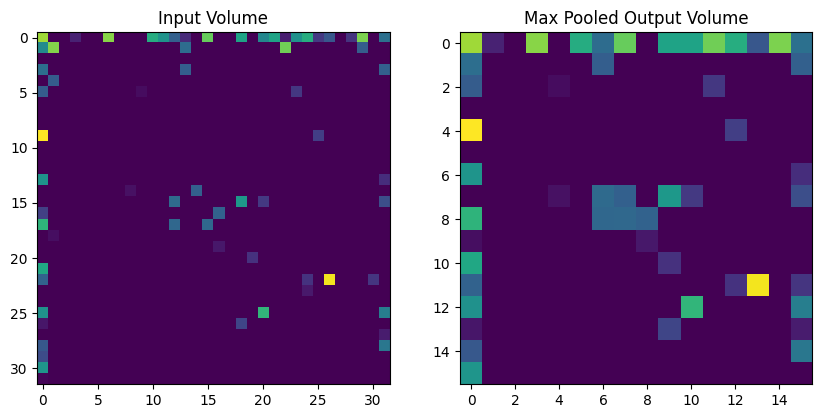

In [58]:
def pooling_layer(input_volume, pool_size=2, stride=2, pool_type='max', plot = True):
    h, w, c = input_volume.shape
    out_height = (h - pool_size) // stride + 1
    out_width = (w - pool_size) // stride + 1
    pooled_volume = np.zeros((out_height, out_width, c))

    for channel in range(c):
        pooled_volume[:, :, channel] = pooling(input_volume[:, :, channel], pool_size, stride, pool_type, plot)
        
    if plot:

        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.title("Input Volume")
        plt.imshow(input_volume[:, :, 0], cmap='viridis')  
        plt.subplot(1, 2, 2)
        plt.title(f"{pool_type.capitalize()} Pooled Output Volume")
        plt.imshow(pooled_volume[:, :, 0], cmap='viridis')  
        plt.show()
    
    # else:
    #     print("No plotting")

    return pooled_volume


pooled_volume = pooling_layer(output_volume, pool_size=2, stride=2, pool_type='max')


In [59]:
def flattening(input_volume):
    flattened_output = input_volume.flatten()
    
    print("Flattened Output Vector:", flattened_output)
    print("Flattened Output Shape:", flattened_output.shape)

    return flattened_output


flattened_output = flattening(pooled_volume)


Flattened Output Vector: [ 658.31126508  798.94445674  810.744163   ... 1209.05949891  686.29594257
  576.01198239]
Flattened Output Shape: (1024,)


In [60]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x))  
    return exp_x / np.sum(exp_x)

def mlp(input_vector, hidden_layers, output_size, activation='relu', apply_softmax=True):
    layers = [input_vector.shape[0]] + hidden_layers + [output_size]
    activations = [input_vector]

    weights = [np.random.randn(layers[i+1], layers[i]) * 0.01 for i in range(len(layers) - 1)]
    biases = [np.random.randn(layers[i+1]) * 0.01 for i in range(len(layers) - 1)]
    
    for i in range(len(hidden_layers)):
        z = weights[i].dot(activations[-1]) + biases[i]
        if activation == 'relu':
            a = relu(z)
        elif activation == 'tanh':
            a = np.tanh(z)
        elif activation == 'sigmoid':
            a = 1 / (1 + np.exp(-z))
        activations.append(a)

    z = weights[-1].dot(activations[-1]) + biases[-1]
    output = softmax(z) if apply_softmax else z
    activations.append(output)

    print("Input Vector:", input_vector)
    print("Output Vector:", output)
    
    return output


output_vector = mlp(flattened_output, hidden_layers=[49], output_size=10, activation='relu', apply_softmax=True)


Input Vector: [ 658.31126508  798.94445674  810.744163   ... 1209.05949891  686.29594257
  576.01198239]
Output Vector: [1.20009298e-16 2.68191731e-08 5.93377524e-28 1.10383373e-11
 1.44153362e-05 3.34222084e-01 1.71952596e-21 7.52503872e-07
 1.86361750e-11 6.65762721e-01]


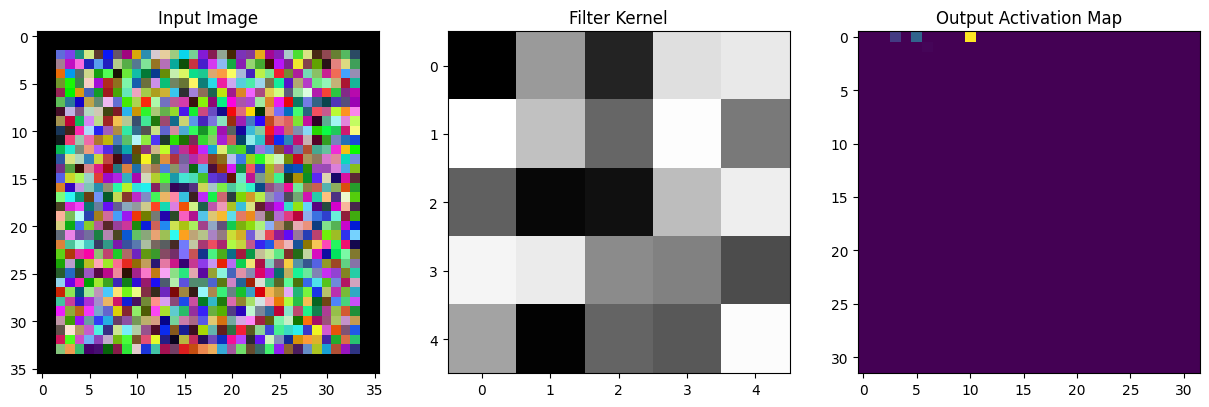

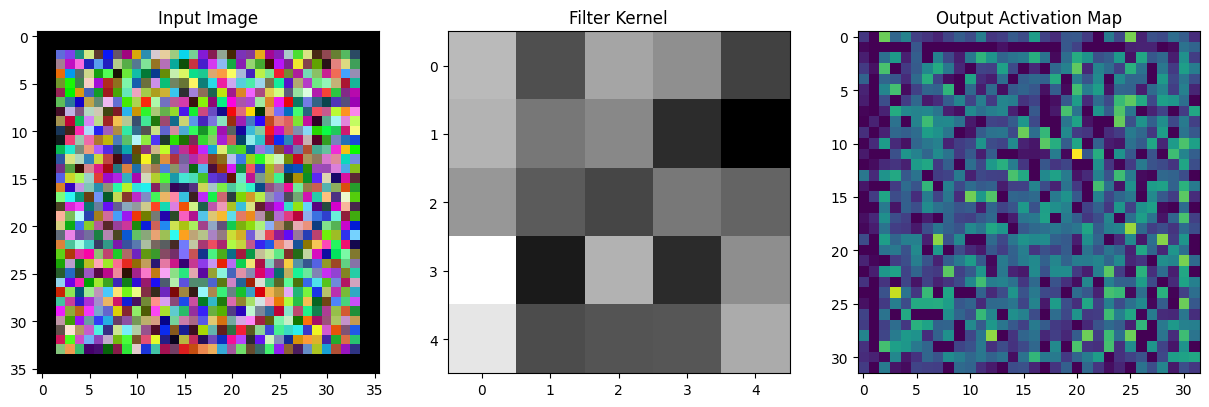

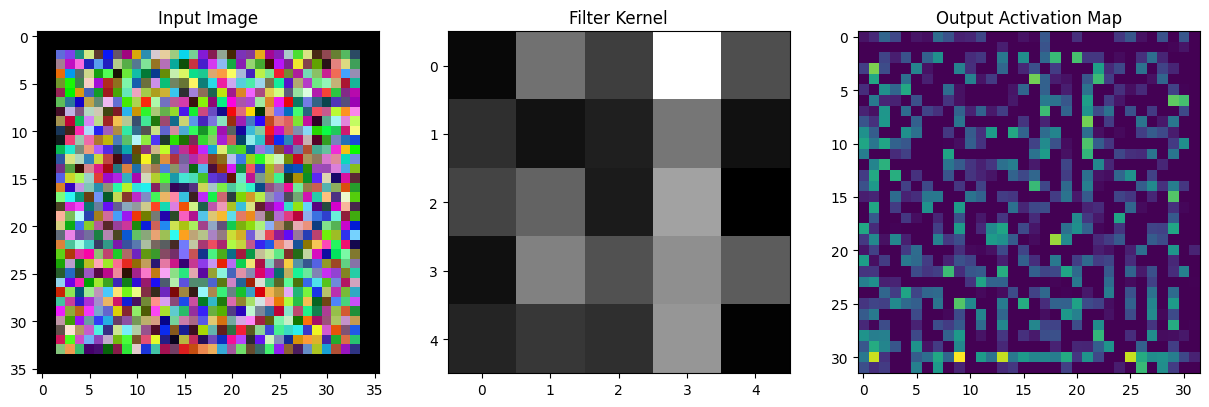

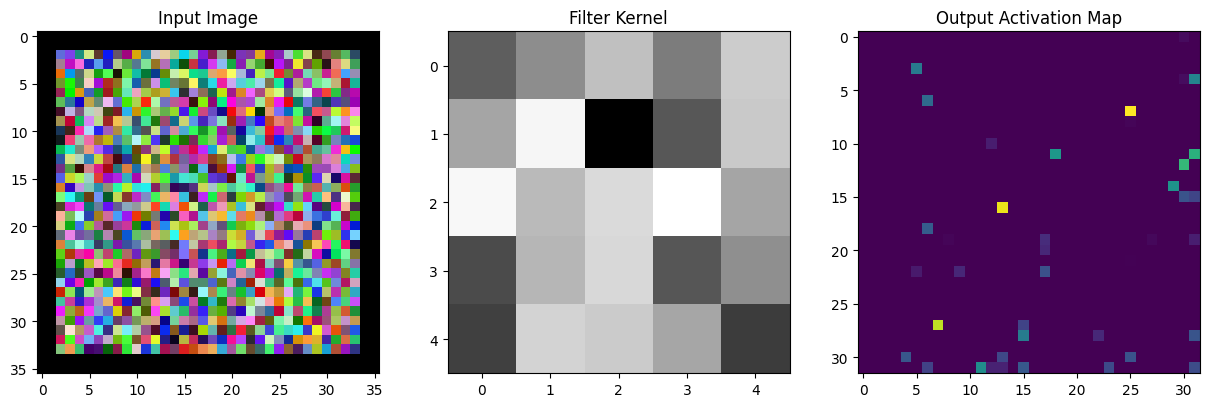

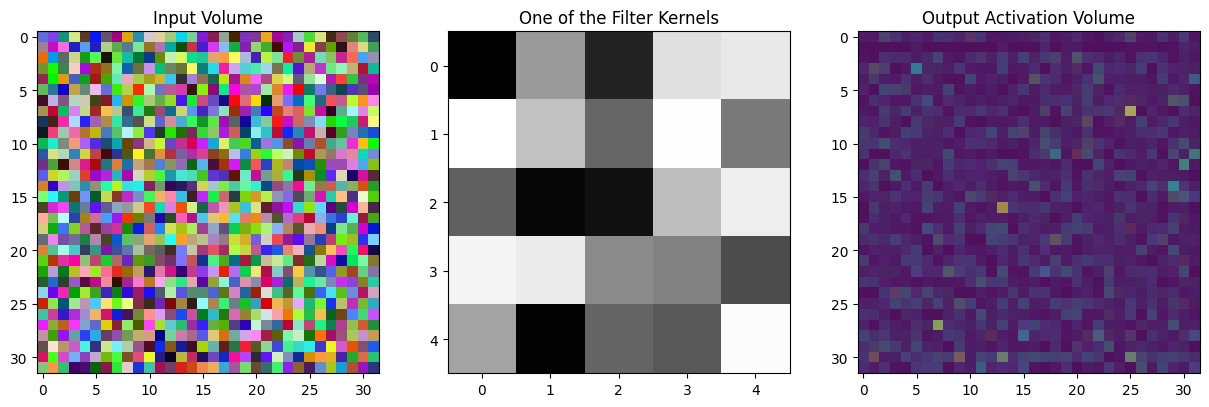

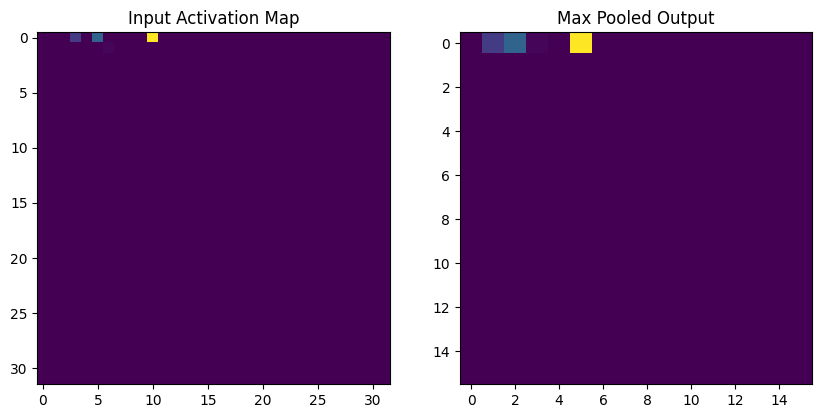

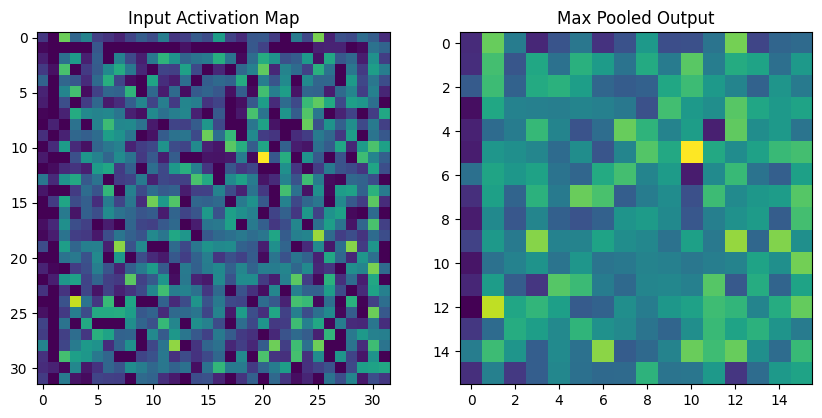

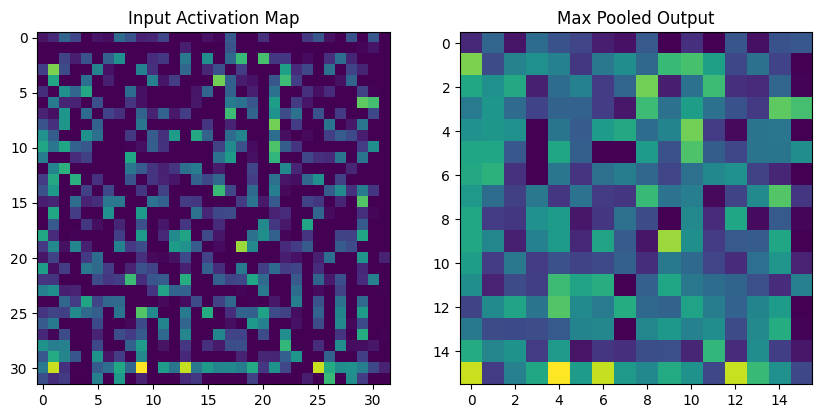

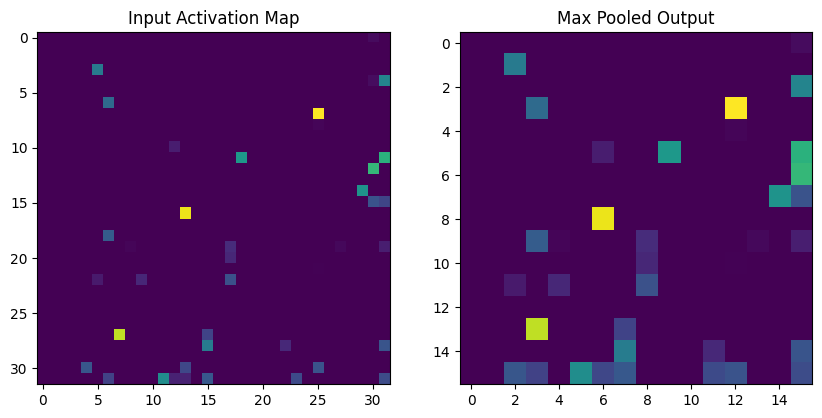

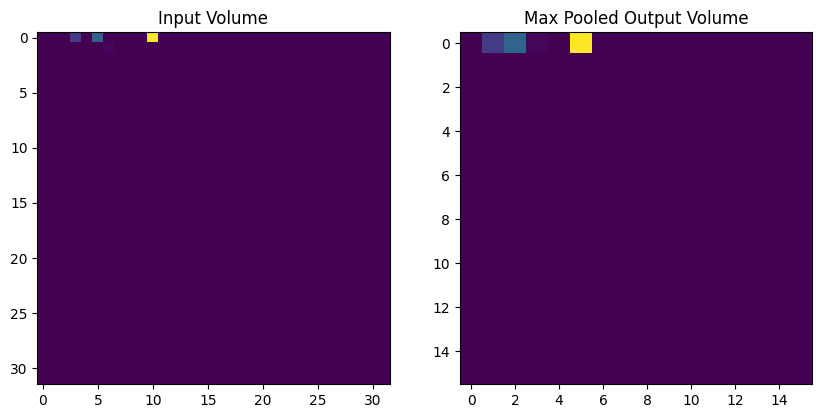

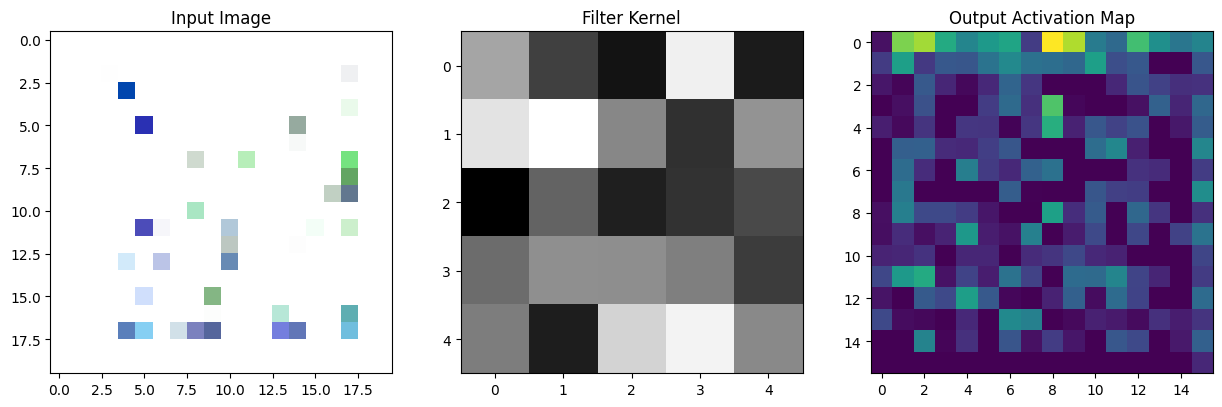

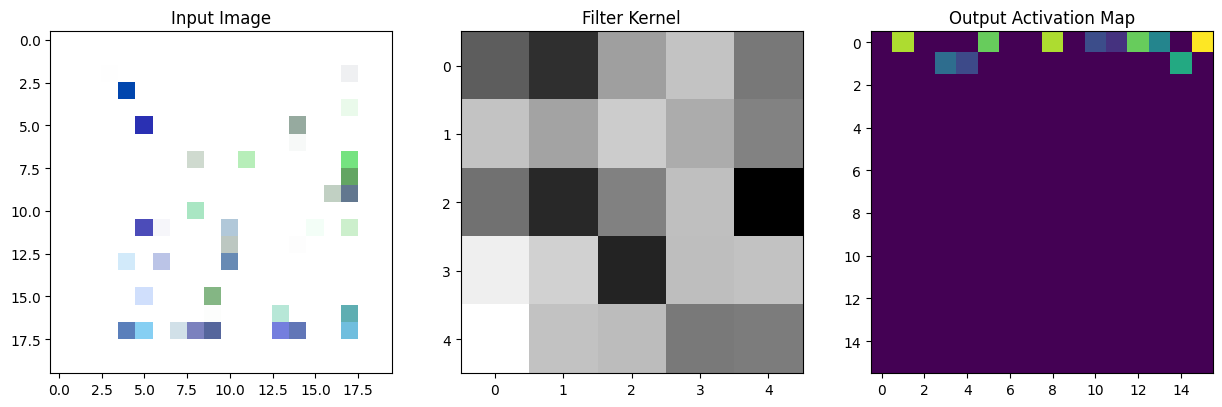

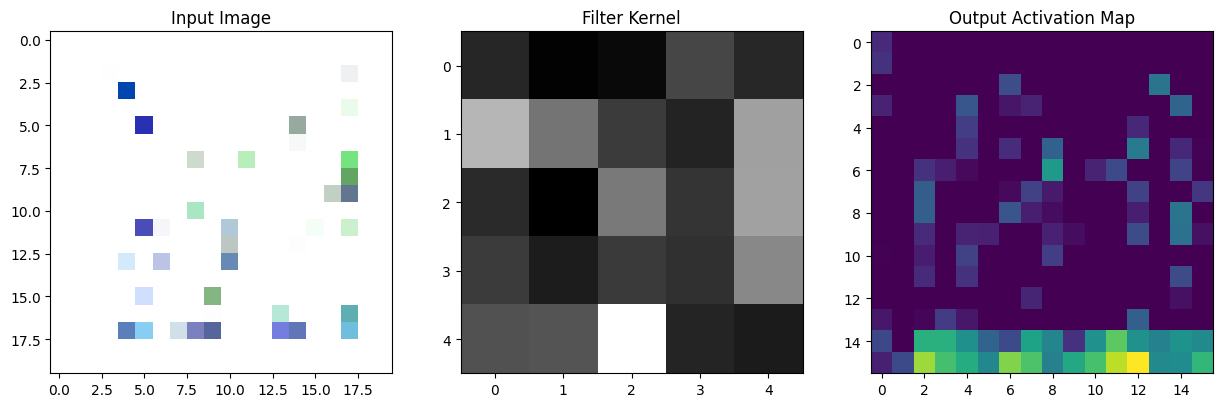

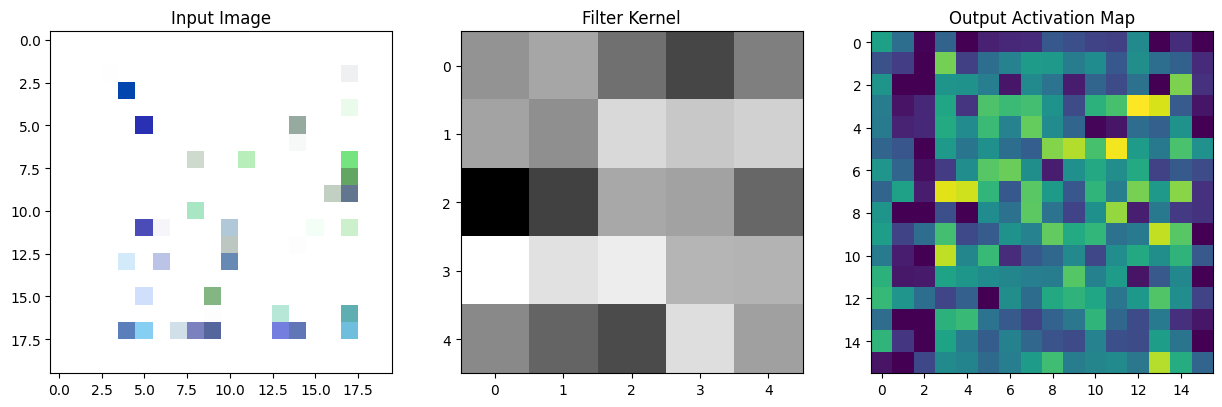

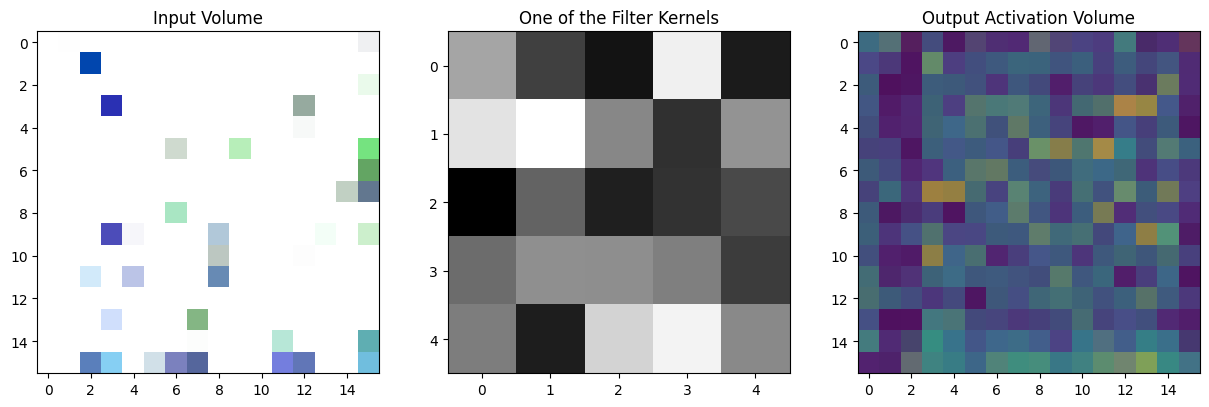

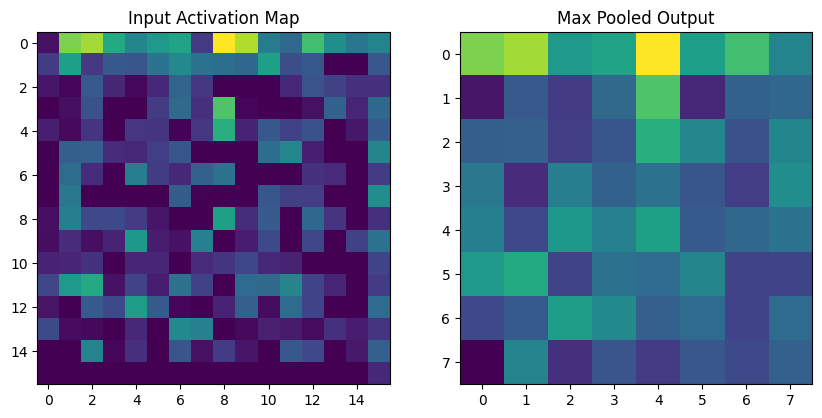

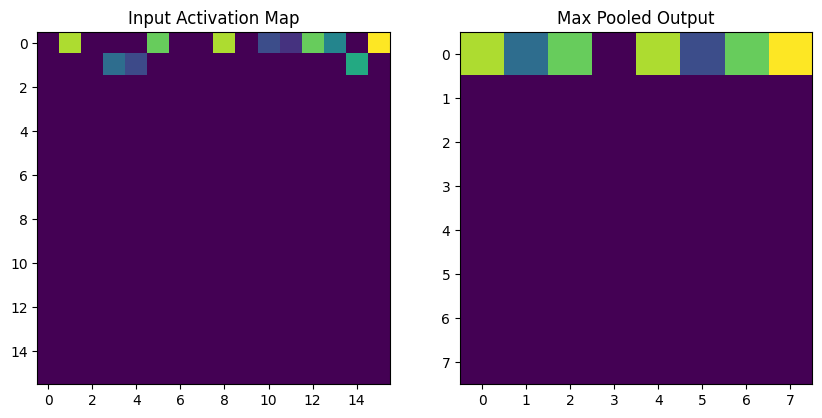

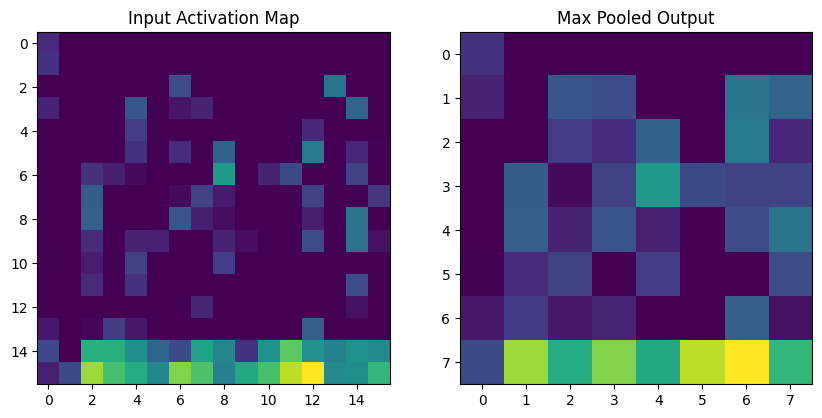

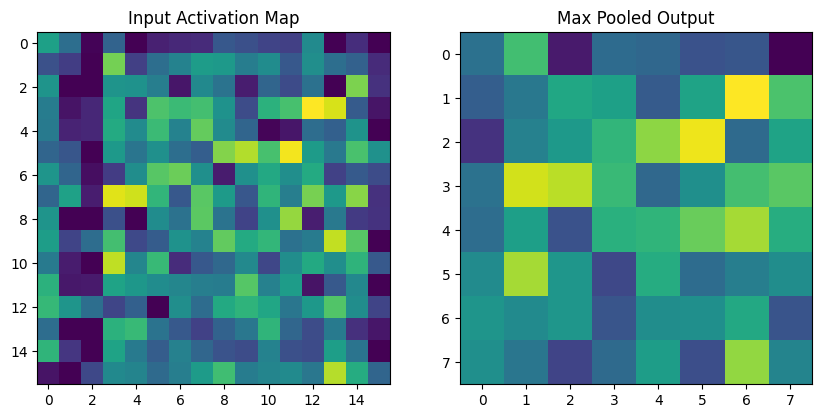

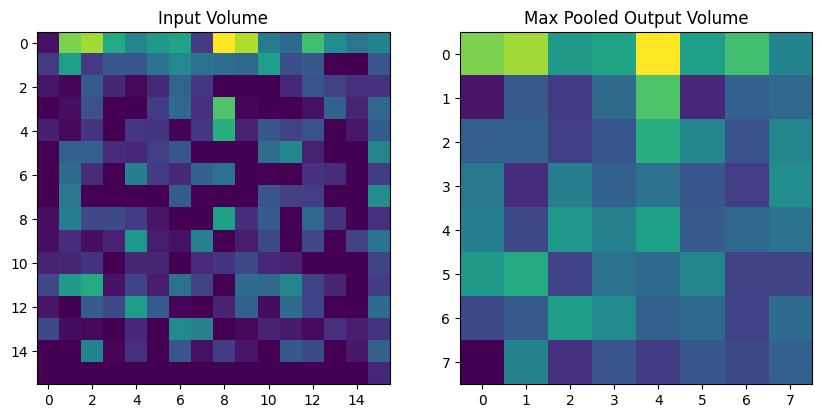

Flattened Output Vector: [13397.93288033  4671.05900132  1984.98500468  7214.89331114
 14348.05101738  1907.72183287     0.         10033.06502688
  8924.02464309  4082.8187009      0.          4589.27199286
  9765.14302763     0.             0.          7004.22148897
 16671.41494672  4677.83991354     0.          6876.66736527
  9429.41460893  1250.03588658     0.          6156.30308628
 11606.17502582  4099.90300763     0.          6277.19317649
  7522.98923755  5328.8644287      0.          3949.20128332
   989.94324555     0.          1313.03685888  6557.78746688
  4644.75922135     0.             0.          7437.28743291
  2944.764119       0.          3566.51196666  9160.92642846
  5745.38257505     0.          3191.49243285  8906.57906796
 12101.0649071      0.             0.          6466.04926353
  1841.15059775     0.             0.          9016.09352631
  5164.09122337     0.          5166.47602776 12683.19415788
  5587.02294087     0.          4311.64464944 10192.82318156

In [65]:
def cnn_feed_forward(input_image, return_bottleneck = False):
    kernels_1 = np.random.randn(4, 5, 5, 3) 
    # print("hey") 
    conv1_output = convolution_layer(input_image, kernels=kernels_1, stride=1, padding=2, activation='relu')
    # print("hey2")

    pool1_output = pooling_layer(conv1_output, pool_size=2, stride=2, pool_type='max')

    kernels_2 = np.random.randn(4, 5, 5, 4)  
    conv2_output = convolution_layer(pool1_output, kernels=kernels_2, stride=1, padding=2, activation='relu')

    pool2_output = pooling_layer(conv2_output, pool_size=2, stride=2, pool_type='max')

    flattened_output = flattening(pool2_output)

    output_vector = mlp(flattened_output, hidden_layers=[49], output_size=10, activation='relu', apply_softmax=True)
    
    if return_bottleneck:
        return output_vector, flattened_output
    
    return output_vector


input_image = np.random.rand(32, 32, 3) * 255
output_vector = cnn_feed_forward(input_image)
print("CNN Output Vector:", output_vector)


No plotting
No plotting
Flattened Output Vector: [10380.00273953  2335.35430929     0.          9414.47258554
  4621.3159458   5939.92849699     0.          5825.10493104
  5447.91246105  2510.68274618     0.          1265.92953291
  4772.50512643  8090.04125863     0.          5245.68147888
  6214.83946134  2847.02964041     0.          3362.23283238
  6798.74708574  9022.52859556     0.          3402.44024278
  7400.62199241  7710.53894354     0.          4526.43052205
  3624.78012078  6299.89960174     0.           884.09174034
  2838.56952898   393.88822995     0.         10124.35633086
     0.          8035.58410973     0.             0.
     0.          6742.24365722     0.             0.
     0.         10809.95345796     0.             0.
     0.         10482.53233157     0.             0.
     0.         16226.82570825     0.             0.
     0.         14144.7261945      0.             0.
     0.         19387.73139922     0.             0.
  2619.812471    5751.82736914 

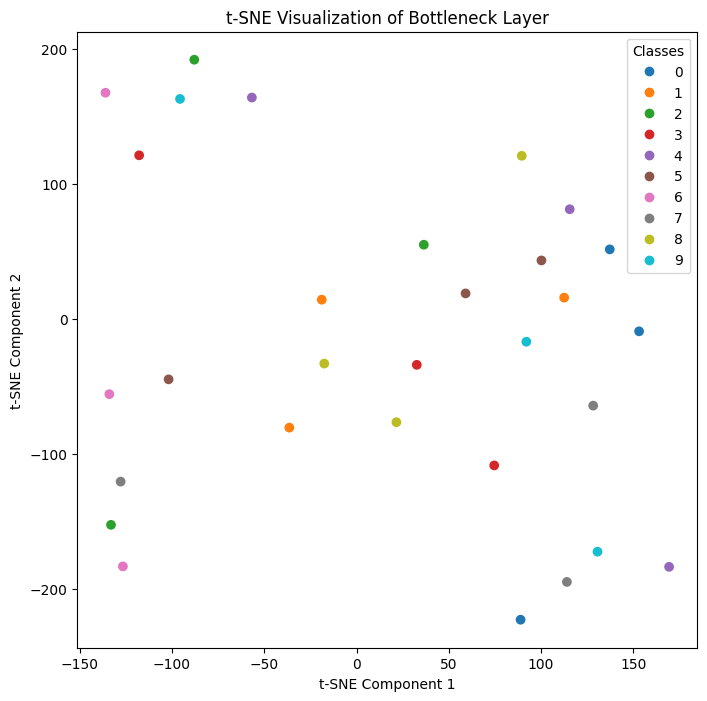

In [67]:
import pickle
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def cnn_feed_forward(input_image, return_bottleneck = False):  #without plotting
    kernels_1 = np.random.randn(4, 5, 5, 3) 
    # print("hey") 
    conv1_output = convolution_layer(input_image, kernels=kernels_1, stride=1, padding=2, activation='relu', plot = False)
    # print("hey2")

    pool1_output = pooling_layer(conv1_output, pool_size=2, stride=2, pool_type='max', plot = False)

    kernels_2 = np.random.randn(4, 5, 5, 4)  
    conv2_output = convolution_layer(pool1_output, kernels=kernels_2, stride=1, padding=2, activation='relu', plot = False)

    pool2_output = pooling_layer(conv2_output, pool_size=2, stride=2, pool_type='max', plot = False)

    flattened_output = flattening(pool2_output)

    output_vector = mlp(flattened_output, hidden_layers=[49], output_size=10, activation='relu', apply_softmax=True)
    
    if return_bottleneck:
        return output_vector, flattened_output
    
    return output_vector


def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def load_cifar10_data(data_dir):
    cifar10_images = []
    cifar10_labels = []


    for i in range(1, 6):
        batch = unpickle(f"{data_dir}/data_batch_{i}")
        cifar10_images.append(batch[b'data'])
        cifar10_labels += batch[b'labels']
    

    cifar10_images = np.vstack(cifar10_images).reshape(-1, 3, 32, 32)
    cifar10_images = cifar10_images.transpose(0, 2, 3, 1) 

    return cifar10_images, cifar10_labels

data_dir = 'cifar-10-batches-py'  
cifar10_images, cifar10_labels = load_cifar10_data(data_dir)

output_vectors = []
for class_id in range(10):
    class_images = [img for img, label in zip(cifar10_images, cifar10_labels) if label == class_id]
    input_image = class_images[0]
    
    output_vector = cnn_feed_forward(input_image)
    output_vectors.append(output_vector)
    
    print(f"Output Vector for Class {class_id}:", output_vector)


def visualize_tsne_bottleneck(cifar10_images, cifar10_labels):
    bottleneck_outputs = []
    labels = []
    
    for class_id in range(10):

        class_images = [img for img, label in zip(cifar10_images, cifar10_labels) if label == class_id][:3]
        
        for input_image in class_images:

            _, bottleneck_output = cnn_feed_forward(input_image, return_bottleneck=True)
            bottleneck_outputs.append(bottleneck_output)
            labels.append(class_id)
    

    tsne = TSNE(n_components=2, random_state=0, perplexity=5)
    bottleneck_outputs = np.array(bottleneck_outputs)
    tsne_results = tsne.fit_transform(bottleneck_outputs)

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', marker='o')
    plt.legend(handles=scatter.legend_elements()[0], labels=range(10), title="Classes")
    plt.title("t-SNE Visualization of Bottleneck Layer")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()


visualize_tsne_bottleneck(cifar10_images, cifar10_labels)


Q2

Files already downloaded and verified
Files already downloaded and verified
Training with Vanilla SGD
Epoch [1/15], Train Loss: 2.2926, Test Loss: 2.2538, Accuracy: 15.92%
Epoch [2/15], Train Loss: 2.0891, Test Loss: 1.9367, Accuracy: 32.15%
Epoch [3/15], Train Loss: 1.8711, Test Loss: 1.8017, Accuracy: 36.61%
Epoch [4/15], Train Loss: 1.7375, Test Loss: 1.6663, Accuracy: 39.82%
Epoch [5/15], Train Loss: 1.6216, Test Loss: 1.6043, Accuracy: 41.54%
Epoch [6/15], Train Loss: 1.5509, Test Loss: 1.5177, Accuracy: 44.51%
Epoch [7/15], Train Loss: 1.4980, Test Loss: 1.4695, Accuracy: 46.37%
Epoch [8/15], Train Loss: 1.4598, Test Loss: 1.4457, Accuracy: 46.97%
Epoch [9/15], Train Loss: 1.4290, Test Loss: 1.4119, Accuracy: 48.95%
Epoch [10/15], Train Loss: 1.4038, Test Loss: 1.4116, Accuracy: 49.13%
Epoch [11/15], Train Loss: 1.3822, Test Loss: 1.3784, Accuracy: 50.18%
Epoch [12/15], Train Loss: 1.3630, Test Loss: 1.3744, Accuracy: 50.39%
Epoch [13/15], Train Loss: 1.3440, Test Loss: 1.3427, A

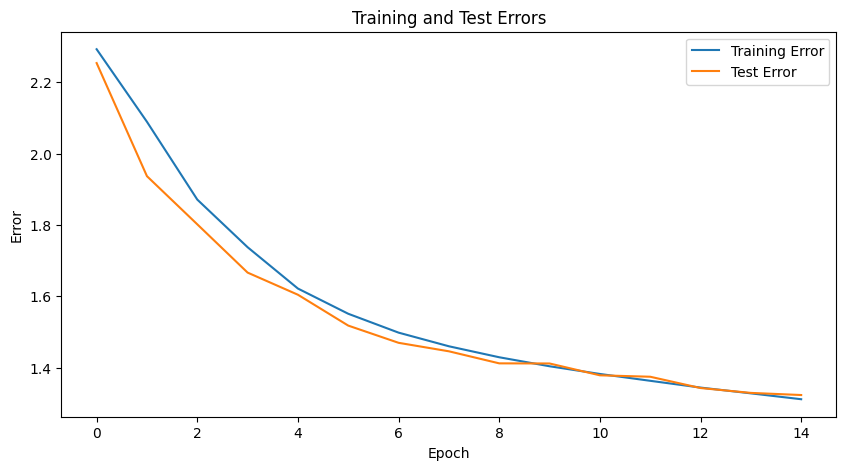

Training with SGD + Momentum
Epoch [1/15], Train Loss: 1.8020, Test Loss: 1.4860, Accuracy: 47.00%
Epoch [2/15], Train Loss: 1.4609, Test Loss: 1.4128, Accuracy: 49.29%
Epoch [3/15], Train Loss: 1.3640, Test Loss: 1.3221, Accuracy: 52.83%
Epoch [4/15], Train Loss: 1.3044, Test Loss: 1.3309, Accuracy: 52.70%
Epoch [5/15], Train Loss: 1.2661, Test Loss: 1.2934, Accuracy: 53.97%
Epoch [6/15], Train Loss: 1.2320, Test Loss: 1.2345, Accuracy: 55.60%
Epoch [7/15], Train Loss: 1.2107, Test Loss: 1.2552, Accuracy: 55.70%
Epoch [8/15], Train Loss: 1.1864, Test Loss: 1.2160, Accuracy: 56.20%
Epoch [9/15], Train Loss: 1.1667, Test Loss: 1.2290, Accuracy: 55.58%
Epoch [10/15], Train Loss: 1.1518, Test Loss: 1.2179, Accuracy: 57.02%
Epoch [11/15], Train Loss: 1.1383, Test Loss: 1.2127, Accuracy: 57.11%
Epoch [12/15], Train Loss: 1.1265, Test Loss: 1.2143, Accuracy: 57.00%
Epoch [13/15], Train Loss: 1.1165, Test Loss: 1.2508, Accuracy: 55.57%
Epoch [14/15], Train Loss: 1.1067, Test Loss: 1.2482, Acc

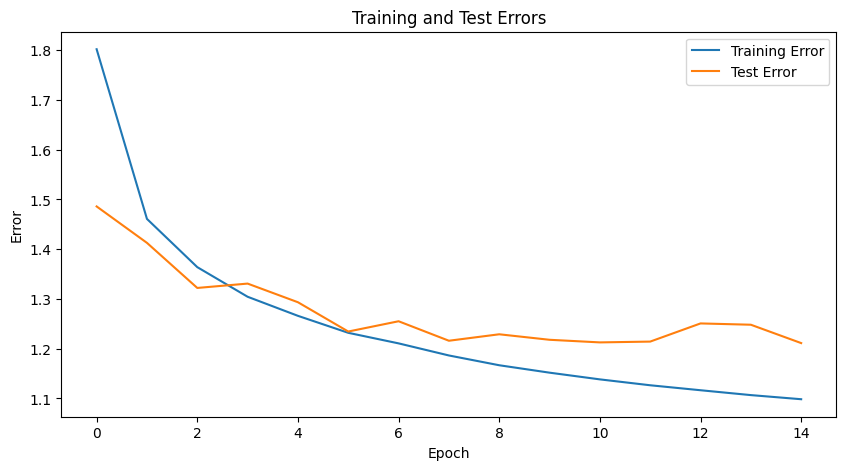

Training with RMSProp
Epoch [1/15], Train Loss: 1.6307, Test Loss: 1.4450, Accuracy: 47.63%
Epoch [2/15], Train Loss: 1.4097, Test Loss: 1.3685, Accuracy: 51.64%
Epoch [3/15], Train Loss: 1.3395, Test Loss: 1.3562, Accuracy: 51.65%
Epoch [4/15], Train Loss: 1.3007, Test Loss: 1.3349, Accuracy: 52.87%
Epoch [5/15], Train Loss: 1.2705, Test Loss: 1.3546, Accuracy: 53.09%
Epoch [6/15], Train Loss: 1.2517, Test Loss: 1.3492, Accuracy: 52.94%
Epoch [7/15], Train Loss: 1.2379, Test Loss: 1.3515, Accuracy: 52.22%
Epoch [8/15], Train Loss: 1.2271, Test Loss: 1.4059, Accuracy: 52.92%
Epoch [9/15], Train Loss: 1.2204, Test Loss: 1.4286, Accuracy: 52.65%
Epoch [10/15], Train Loss: 1.2136, Test Loss: 1.3139, Accuracy: 55.24%
Epoch [11/15], Train Loss: 1.2126, Test Loss: 1.2310, Accuracy: 57.39%
Epoch [12/15], Train Loss: 1.2095, Test Loss: 1.3021, Accuracy: 54.59%
Epoch [13/15], Train Loss: 1.2098, Test Loss: 1.2922, Accuracy: 55.90%
Epoch [14/15], Train Loss: 1.2100, Test Loss: 1.3104, Accuracy: 

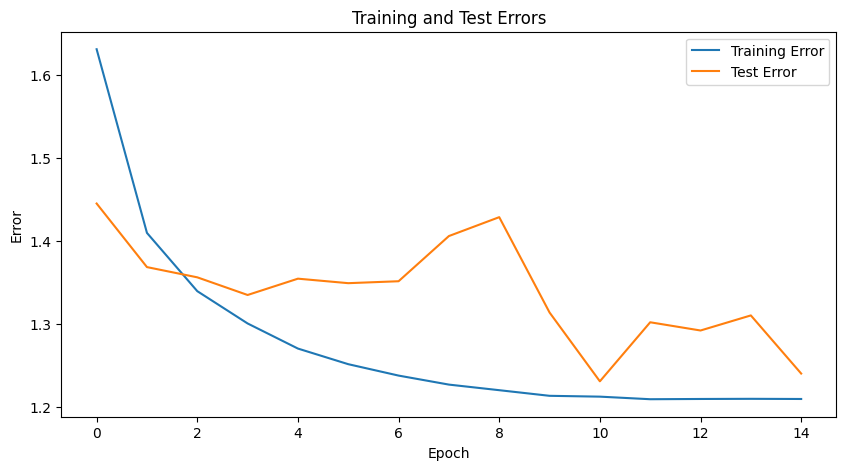

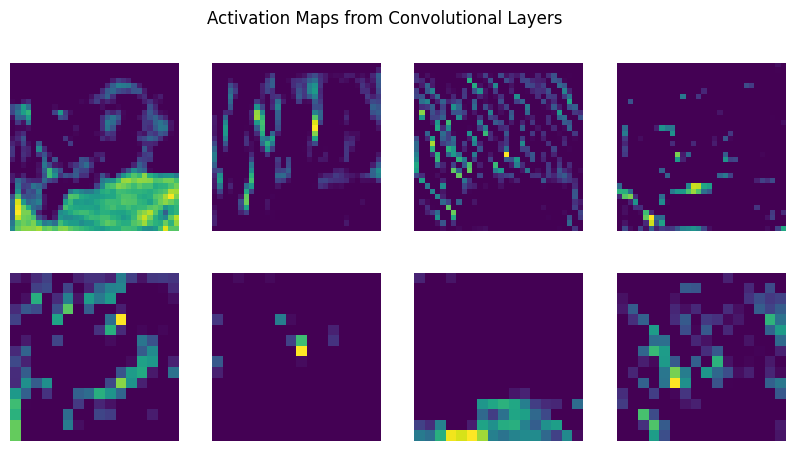

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size=5, stride=1, padding=2)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                 
        self.conv2 = nn.Conv2d(4, 4, kernel_size=5, stride=1, padding=2) 
        self.fc1 = nn.Linear(4 * 8 * 8, 49)  
        self.fc2 = nn.Linear(49, 10)         

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 4 * 8 * 8)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

def train_and_evaluate(model, optimizer, criterion, num_epochs=15):
    train_errors, test_errors = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            optimizer.zero_grad()                
            outputs = model(images)
            loss = criterion(outputs, labels)    
            loss.backward()                      
            optimizer.step()                     
            running_loss += loss.item()

        train_errors.append(running_loss / len(train_loader))

        model.eval()
        test_loss, correct = 0.0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        test_errors.append(test_loss / len(test_loader))
        accuracy = correct / len(test_dataset)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_errors[-1]:.4f}, "
              f"Test Loss: {test_errors[-1]:.4f}, Accuracy: {accuracy * 100:.2f}%")

    return train_errors, test_errors

def plot_errors(train_errors, test_errors):
    plt.figure(figsize=(10, 5))
    plt.plot(train_errors, label='Training Error')
    plt.plot(test_errors, label='Test Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.title('Training and Test Errors')
    plt.show()

def visualize_activations(model, image):
    model.eval()
    activations = []

    x = torch.relu(model.conv1(image))
    activations.append(x[0, :4].detach().numpy())  
    x = model.pool(x)

    x = torch.relu(model.conv2(x))
    activations.append(x[0, :4].detach().numpy())  
    x = model.pool(x)

    fig, axes = plt.subplots(2, 4, figsize=(10, 5))
    for i in range(2):
        for j in range(4):
            axes[i, j].imshow(activations[i][j], cmap='viridis')
            axes[i, j].axis('off')
    plt.suptitle('Activation Maps from Convolutional Layers')
    plt.show()

model = CNNModel()
criterion = nn.CrossEntropyLoss()

print("Training with Vanilla SGD")
optimizer_sgd = optim.SGD(model.parameters(), lr=0.001)
train_errors_sgd, test_errors_sgd = train_and_evaluate(model, optimizer_sgd, criterion)
plot_errors(train_errors_sgd, test_errors_sgd)

print("Training with SGD + Momentum")
model = CNNModel()  
optimizer_momentum = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_errors_momentum, test_errors_momentum = train_and_evaluate(model, optimizer_momentum, criterion)
plot_errors(train_errors_momentum, test_errors_momentum)

print("Training with RMSProp")
model = CNNModel()  
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
train_errors_rmsprop, test_errors_rmsprop = train_and_evaluate(model, optimizer_rmsprop, criterion)
plot_errors(train_errors_rmsprop, test_errors_rmsprop)

sample_image, _ = next(iter(test_loader))  
visualize_activations(model, sample_image[0].unsqueeze(0))  


In [13]:
!pip install torchvision

  Using cached torchvision-0.20.1-cp311-cp311-win_amd64.whl (1.6 MB)



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: C:\Users\SAKSHAM\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
